# Generate Atom-mapped SMILES for RMG reactions.
This notebook helps create atom-mapped SMILES for reactants and products. Two methods are available:

1. Atommapping according to the templates of RMG reaction families.
2. Atommapping using RXNMapper and in-house H atom mappings.

## Import Modules

In [1]:
import os
import sys
# To add RDMC into PYTHONPATH in case you haven't done
sys.path.append(os.path.dirname(os.path.abspath('')))

from rdmc.mol import RDKitMol, parse_xyz_or_smiles_list
from rdmc.ts import get_formed_and_broken_bonds
from rdmc.reaction import Reaction

# Import RMG dependencies
# You can install RMG according to http://reactionmechanismgenerator.github.io/RMG-Py/users/rmg/installation
# Loading RMG may take a while
try:
    print('Importing RMG modules...')
    print('This step may takes a while...')
    from rdmc.external.rmg import (from_rdkit_mol,
                                   load_rxn_family_database,
                                   generate_reaction_complex,)
    # Load RMG database
    database = load_rxn_family_database(families='all')
except (ImportError, ModuleNotFoundError):
    print('You need to install RMG to use RMG for atommapping!')

    
# Import RXNMapper
# You can install RXNMapper by `pip install rxnmapper`
try:
   
    print('Importing RXNMappers modules...')
    from rxnmapper import RXNMapper
except (ImportError, ModuleNotFoundError):
    print('You need to install RXNMapper to use RXNMapper for atommapping!')
    
%load_ext autoreload
%autoreload 2

Importing RMG modules...
This step may takes a while...
Importing RXNMappers modules...


## Examples
You can choose whichever reaction you like, and you are encouraged to provide your own example.

For carbenes and biradicals, you need to specify the multiplicity as well. E.g., `reactants=[('[CH2]', 1)]`

H_migration

In [2]:
reactants = [
"""[CH2]CCCCO""",]
products = [
"""[O]CCCCC""",]

Retroene

In [3]:
reactants = [
"""C1=CC(C2C=CCC2)C=C1""",]

products = [
"""C1=CC=CC1""",
"""C1=CC=CC1""",]

H abstraction

In [4]:
reactants = [
"""[O]""",
"""CCCCO""",]

products = [
"""[OH]""",
"""[CH2]CCCO""",]

1+2_Cycloaddition

In [5]:
reactants = [
("""[O]""", 1),
"""C=C""",]

products = [
"""C1OC1""",]

H2_elimination

In [6]:
reactants = [
    """CC""", ]

products = [
    """C=C""",
    """[H][H]""",]

1,2_Insertion_carbene

In [7]:
reactants = [
    ("""[CH2]""", 1),
    """C=C""", ]

products = [
    """CC=C""", ]

# [Method 1] Atommapping using RMG

In [8]:
print("You can neglect the Open Babel Warnings below.")
try:
    # Generate RMG Molecule
    r_mols = parse_xyz_or_smiles_list(reactants)
    p_mols = parse_xyz_or_smiles_list(products)
    reactant_molecules = [from_rdkit_mol(r) for r in r_mols]
    product_molecules = [from_rdkit_mol(p) for p in p_mols]

except Exception as e:
    print(e)
    print('Have issues generating molecules.')
else:
    # A product complex with the same atom indexing as the reactant is generated
    reactant_complex, product_complex = generate_reaction_complex(
                                            database,
                                            reactant_molecules,
                                            product_molecules,
                                            verbose=True)

if reactant_complex:
    r_complex = RDKitMol.FromRMGMol(reactant_complex)
    p_complex = RDKitMol.FromRMGMol(product_complex)

You can neglect the Open Babel Warnings below.


*** Open Babel Warning  in ReadMolecule
  Problems reading an XYZ file: The first line must contain the number of atoms.
*** Open Babel Warning  in ReadMolecule
  Problems reading an XYZ file: The first line must contain the number of atoms.
*** Open Babel Warning  in ReadMolecule
  Problems reading an XYZ file: The first line must contain the number of atoms.


C=C + [CH2] <=> C=CC
RMG family: 1,2_Insertion_carbene
Is forward reaction: True


### Generate Reaction SMILES

Visualize reactant and product in molecule graphs

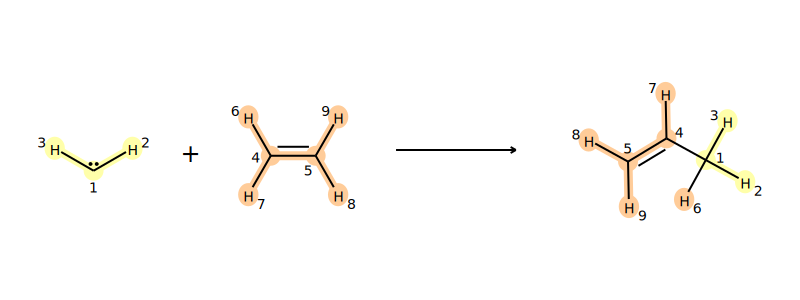

[C:1]([H:2])[H:3].[C:4](=[C:5]([H:8])[H:9])([H:6])[H:7]>>[C:1]([H:2])([H:3])([C:4](=[C:5]([H:8])[H:9])[H:7])[H:6]


In [9]:
rxn = Reaction(r_complex, p_complex)
display(rxn)
print(rxn.to_smiles())

# [Method 2] Atommapping using RXNMapper (Beta)

### Map heavy atoms using RXNMapper

Based on version 90a7012c9c0127f4a347baf815e270d8807b5a39

[Developer TODO]

- A deeper investigation in rxn_mapper is need in the future to check possibilities of built-in H mapping 
- modularize the following cells

In [10]:
rxn_mapper = RXNMapper()
r_complex_smi = ".".join([rsmi[0] if isinstance(rsmi, tuple) else rsmi for rsmi in reactants])
p_complex_smi = ".".join([psmi[0] if isinstance(psmi, tuple) else psmi for psmi in products])
rxns = [r_complex_smi + '>>' + p_complex_smi,]
atommapped_rxn_smi = rxn_mapper.get_attention_guided_atom_maps(rxns)[0]['mapped_rxn']

Some weights of the model checkpoint at /Users/xiaorui/Apps/mambaforge/envs/rmg_3.2/lib/python3.7/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


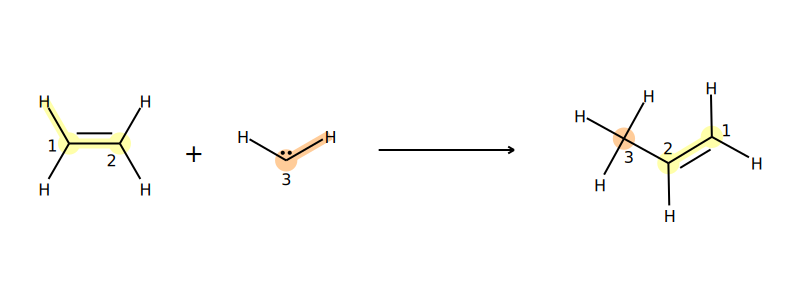

In [11]:
rxn = Reaction.from_reaction_smiles(atommapped_rxn_smi)
display(rxn)
r_complex = rxn.reactant_complex
p_complex = rxn.product_complex

### Sort Heavy Atoms

In [12]:
# There are cases with unequal number of atoms labeled with atom map index. Known cases:
# - H will not be labeled in most case but will be labeled if there is a [H][H] or [H]
H_atoms = []
if max(r_complex.GetAtomMapNumbers()) != max(p_complex.GetAtomMapNumbers()):
    # There are H2
    H_atoms = [i - 1 for i in 
               set(r_complex.GetAtomMapNumbers()).symmetric_difference(p_complex.GetAtomMapNumbers())]

atommap_id_counter = max(r_complex.GetAtomMapNumbers()) + 1
for ratom in r_complex.GetAtoms():
    if ratom.GetAtomMapNum() == 0:
        ratom.SetAtomMapNum(atommap_id_counter)
        atommap_id_counter += 1

atommap_id_counter = max(p_complex.GetAtomMapNumbers()) + 1
for patom in p_complex.GetAtoms():
    if patom.GetAtomMapNum() == 0:
        patom.SetAtomMapNum(atommap_id_counter)
        atommap_id_counter += 1

r_complex = r_complex.RenumberAtoms()
p_complex = p_complex.RenumberAtoms()

### Map non-reacting H atoms

In [13]:
# Check each heavy atoms and and match non-reacting H atoms assuming minimal bond change

unused_ratom_ids = []
unset_patom_ids = []
for ratom in r_complex.GetAtoms():

    # Skip H atoms
    if ratom.GetAtomicNum() == 1:
        continue

    patom = p_complex.GetAtomWithIdx(ratom.GetIdx())
    rH_nbs, pH_nbs = [], []
    
    for rnb in ratom.GetNeighbors():
        if rnb.GetAtomicNum() == 1:
            rH_nbs.append(rnb.GetIdx())
    for pnb in patom.GetNeighbors():
        if pnb.GetAtomicNum() == 1:
            pH_nbs.append(pnb.GetIdx())
    
    for rH_idx, pH_idx in zip(rH_nbs, pH_nbs):
        p_complex.GetAtomWithIdx(pH_idx).SetAtomMapNum(
            r_complex.GetAtomWithIdx(rH_idx).GetAtomMapNum())
        
    if len(rH_nbs) > len(pH_nbs):
        unused_ratom_ids.extend(rH_nbs[len(pH_nbs):])
    elif len(rH_nbs) < len(pH_nbs):
        unset_patom_ids.extend(pH_nbs[len(rH_nbs):])

### Map reacting H atoms

In [14]:
if H_atoms:
    # Can only handle H2 generation without H migration
    if (len(unused_ratom_ids) == 0) and (len(unset_patom_ids) == len(H_atoms)):
        # There is H2 in reactants
        for rH_idx, pH_idx in zip(H_atoms, unset_patom_ids):
            p_complex.GetAtomWithIdx(pH_idx).SetAtomMapNum(r_complex.GetAtomWithIdx(rH_idx).GetAtomMapNum())
    elif (len(unset_patom_ids) == 0) and (len(unused_ratom_ids) == len(H_atoms)):
        # There is H2 in products
        for rH_idx, pH_idx in zip(unused_ratom_ids, H_atoms):
            p_complex.GetAtomWithIdx(pH_idx).SetAtomMapNum(r_complex.GetAtomWithIdx(rH_idx).GetAtomMapNum())
    else:
        raise Runtime('Unexpected behavior in atommapping')
else:
    assert len(unused_ratom_ids) == len(unset_patom_ids), 'Unexpected behavior when assigning H atommapping'
    if len(unused_ratom_ids) > 1:
        from itertools import permutations
        import numpy as np

        min_num_bond_change = np.inf
        opt_pairs = []
        for pairs in permutations(zip(unused_ratom_ids, unset_patom_ids)):
            for rH_idx, pH_idx in pairs:
                p_complex.GetAtomWithIdx(pH_idx).SetAtomMapNum(r_complex.GetAtomWithIdx(rH_idx).GetAtomMapNum())
            formed, broken = get_formed_and_broken_bonds(r_complex, p_complex.RenumberAtoms())
            if len(formed + broken) < min_num_bond_change:
                opt_pairs = pairs
    elif len(unused_ratom_ids) == 1:
        opt_pairs = ((unused_ratom_ids[0], unset_patom_ids[0]),)
    else:
        opt_pairs = tuple()

    for rH_idx, pH_idx in opt_pairs:
        p_complex.GetAtomWithIdx(pH_idx).SetAtomMapNum(r_complex.GetAtomWithIdx(rH_idx).GetAtomMapNum())
p_complex = p_complex.RenumberAtoms()

### Generate Reaction Smiles

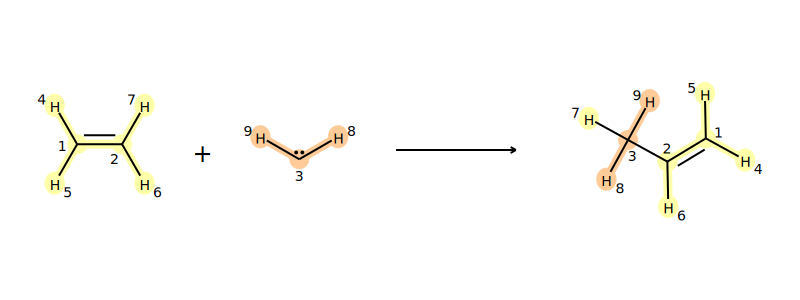

[C:1](=[C:2]([H:6])[H:7])([H:4])[H:5].[C:3]([H:8])[H:9]>>[C:1](=[C:2]([C:3]([H:7])([H:8])[H:9])[H:6])([H:4])[H:5]


In [15]:
new_rxn = Reaction(r_complex, p_complex)
display(new_rxn)
print(new_rxn.to_smiles())